In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import animation, rc
from matplotlib.widgets import Slider, Button, RadioButtons

import matplotlib


# Function

In [9]:
domain_definition = (-np.pi, np.pi)
def f(x):
    return (np.cos(2*x)*np.sin(5*x)+np.sin(x)+2)/3.*(0.5*x**2+0.2*x)
def gradf(x):
    return (-2*np.sin(2*x)*np.sin(5*x)+5*np.cos(2*x)*np.cos(5*x)+np.cos(x))/3.*(0.5*x**2+0.2*x)+(x+0.2)*(np.cos(2*x)*np.sin(5*x)+np.sin(x)+2)/3.

# Optimizer

In [10]:
def adam(grad, u, iteration, **kwargs):
    B_1 = kwargs['B1']
    B_2 = kwargs['B2']
    epsilon = kwargs['epsilon']
    lr = kwargs['initial_lr']/math.sqrt(iteration)
    
    m_b = B_1*u['m_b']+(1-B_1)*grad
    v_b = B_2*u['v_b']+(1-B_2)*(grad**2)
    m_unb = u['m_b']/(1-(B_1**iteration))
    v_unb = u['v_b']/(1-(B_2**iteration))
    u['m_b'] = m_b
    u['v_b'] = v_b
    return -(lr*m_unb)/(math.sqrt(v_unb)+epsilon)

def sgd(grad, u, iteration, **kwargs):
    lr = kwargs['initial_lr']/math.sqrt(iteration)
    return -lr*grad

def adamax(grad, u, iteration, **kwargs):
    B_1 = kwargs['B1']
    B_2 = kwargs['B2']
    epsilon = kwargs['epsilon']
    lr = kwargs['initial_lr']/math.sqrt(iteration)

    m_b = B_1*u['m_b']+(1-B_1)*grad
    
    v_b = max(grad**2, B_2*u['v_b'])
    m_unb = u['m_b']/(1-B_1**iteration)
    u['m_b'] = m_b
    u['v_b'] = v_b
    return -(lr*m_unb)/(math.sqrt(v_b)+epsilon)

def adagrad(grad, u, iteration, **kwargs):
    lr = kwargs['initial_lr']/math.sqrt(iteration)
    epsilon = kwargs['epsilon']
    v_b = u['v_b']
    u['v_b'] += grad**2
    return -(lr*grad)/(math.sqrt(v_b)+epsilon)

def RMSprop(grad, u, iteration, **kwargs):
    B_2 = kwargs['B2']
    epsilon = kwargs['epsilon']    
    lr = kwargs['initial_lr']/math.sqrt(iteration)
    v_b = B_2*u['v_b']+(1-B_2)*(grad**2)
    u['v_b'] = v_b
    return -(lr*grad)/(math.sqrt(v_b)+epsilon)
    

def ams(grad, u, iteration, **kwargs):
    B_1 = kwargs['B1']
    B_2 = kwargs['B2']
    epsilon = kwargs['epsilon']
    lr = kwargs['initial_lr']/math.sqrt(iteration)

    m_b = B_1*u['m_b']+(1-B_1)*grad
    v_b = B_2*u['v_b']+(1-B_2)*(grad**2)
    m_unb = u['m_b']/(1-B_1**iteration)
    v_unb = u['v_b']/(1-B_2**iteration)
    u['m_b'] = m_b
    u['v_b'] = v_b
    v_unb = max(u['v_unb'], v_b)
    u['v_unb'] = v_unb
    return -(lr*m_unb)/(math.sqrt(v_unb)+epsilon)

# Parameters

<IPython.core.display.Javascript object>


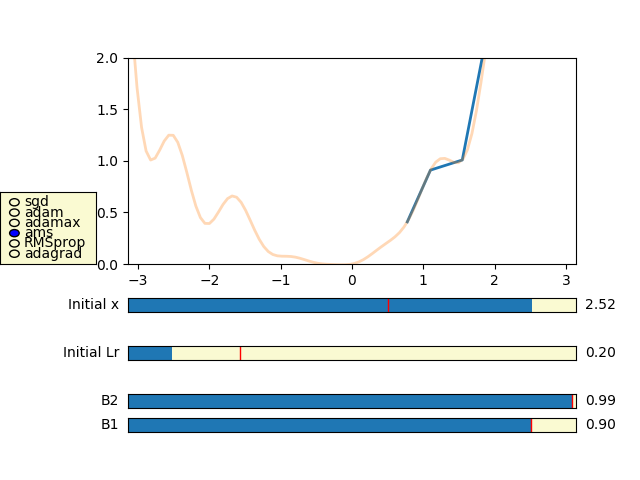

In [12]:
hyperparams = dict(B1 = 0.9, B2 = 0.99, epsilon = 1e-8, initial_lr=0.5, init_x = 0.5)
optimizer = dict(default=sgd)

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.20, bottom=0.45)
ax.set_xlim(*domain_definition)
ax.set_ylim(0,2)

axcolor = 'lightgoldenrodyellow'
axb1 = plt.axes([0.20, 0.1, 0.7, 0.03], facecolor=axcolor)
axb2 = plt.axes([0.20, 0.15, 0.7, 0.03], facecolor=axcolor)
axlr = plt.axes([0.20, 0.25, 0.7, 0.03], facecolor=axcolor)
axinit_x = plt.axes([0.20, 0.35, 0.7, 0.03], facecolor=axcolor)

sb1 = Slider(axb1, 'B1', 0., 1.0, valinit=0.9)
sb2 = Slider(axb2, 'B2', 0., 1.0, valinit=0.99)
sblr = Slider(axlr, 'Initial Lr', 0., 2.0, valinit=0.5)
sbx = Slider(axinit_x, 'Initial x', domain_definition[0], domain_definition[1], valinit=0.5)

def update(val):
    hyperparams['B1'] = float(sb1.val)
    hyperparams['B2'] = float(sb2.val)
    hyperparams['initial_lr'] = float(sblr.val)
    hyperparams['init_x'] = float(sbx.val)
    

sb1.on_changed(update)
sb2.on_changed(update)
sblr.on_changed(update)
sbx.on_changed(update)


axRadio = plt.axes([0.0, 0.45, 0.15, 0.15], facecolor=axcolor)
radio = RadioButtons(axRadio, ('sgd', 'adam', 'adamax', 'ams', 'RMSprop', 'adagrad'))

def optimFunc(label):
    optimdict = {'sgd':sgd, 'adam':adam, 'adamax':adamax, 'ams':ams, 'adagrad': adagrad, 'RMSprop': RMSprop}
    optimizer['default'] = optimdict[label] 

radio.on_clicked(optimFunc)

MAX_SEGMENT = 5
MAX_ITER = 100
line, = ax.plot([], [], lw=2)
lineBG, = ax.plot([], [], lw=2, alpha=0.3)

def init():
    x_curve = np.linspace(domain_definition[0], domain_definition[1], 100)
    lineBG.set_data(x_curve, f(x_curve))
    return (lineBG,)

def train_gen():
    params = [hyperparams['init_x']]
    losses = [f(params[0])]
    momentum = {'m_b':0, 'v_b':0, 'v_unb':0}
    cnt = 0
    while cnt < MAX_ITER:
        cnt += 1
        previous_x = params[-1] 
        previous_loss = losses[-1]
        optim = optimizer['default']
        step_x = optim(gradf(previous_x), momentum, cnt, **hyperparams)
        x = np.clip(previous_x + step_x, domain_definition[0], domain_definition[1])
        loss = f(x)
        params.append(x)
        losses.append(loss)
        if cnt > MAX_SEGMENT:
            del params[:-MAX_SEGMENT]
            del losses[:-MAX_SEGMENT]

        yield params, losses

def animate(data):    
    x, loss = data
    
    line.set_data(x, loss)
    return (line,)

anim = animation.FuncAnimation(fig, animate, train_gen, init_func=init, repeat=True, interval=50, blit=True)
plt.show()